<a href="https://colab.research.google.com/github/lhyochan7/MRI-analysis/blob/main/MRI_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install patchify
import nibabel as nib
import tensorflow as tf
import numpy as np
import keras
import os
import glob
import time
import datetime
from nibabel.viewers import OrthoSlicer3D

from patchify import patchify, unpatchify
from matplotlib import pyplot as plt
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.models import Input
from keras.layers import Conv3D
from keras.layers import Conv3DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from numpy import savez_compressed


In [6]:
class DataLoader():

  def __init__(self, o_path, t_path):

    self.o_dataset = []
    self.t_dataset = []
    self.org_list = []
    self.tar_list = []
    self.o_path = o_path
    self.t_path = t_path
    self.filename = 'dataset.npz'


  def preprocess(self):
    
    fig = plt.figure(figsize=(10,30))

    for org_file in glob.glob(self.o_path):
      org_base = os.path.basename(org_file)
      org_base = org_base[0:15]
      for tar_file in glob.glob(self.t_path):
          tar_base = os.path.basename(tar_file)
          tar_base = tar_base[0:15]

          if tar_base == org_base:
            org_img = nib.load(org_file)
            tar_img = nib.load(tar_file)

            # convert nii file to numpy array
            data1 = org_img.get_fdata()
            data2 = tar_img.get_fdata()

            self.org_list.append(data1)
            self.tar_list.append(data2)

    num = 1

    # patchify and convert to tensor
    for o_data in self.org_list:
      src_patches = patchify(o_data, (64,64,64), step = 32)
      
      '''
      ax1 = fig.add_subplot(len(self.org_list),2,num)
      ax1.set_title('Base-Level')
      ax1.imshow(src_patches[1,2,3,:,:,40])
      num += 2
      '''
      
      # combine vectors 4 x 5 x 4 to 80 patches
      input_img = np.reshape(src_patches, (-1, src_patches.shape[3], src_patches.shape[4], src_patches.shape[5], 1)) # n_patches, x, y, z
      input_img = tf.convert_to_tensor(input_img, np.float32)
      self.o_dataset.append(input_img)

    num = 2

    # patchify and convert to tensor
    for t_data in self.tar_list:
      target_patches = patchify(t_data, (64,64,64), step = 32)  
      
      '''
      ax2 = fig.add_subplot(len(self.tar_list),2,num)
      ax2.set_title('Target')
      ax2.imshow(target_patches[1,2,3,:,:,40])
      num += 2
      '''
      
      # combine vectors 4 x 5 x 4 to 80 patches
      input_img = np.reshape(src_patches, (-1, src_patches.shape[3], src_patches.shape[4], src_patches.shape[5], 1)) # n_patches, x, y, z
      input_img = tf.convert_to_tensor(input_img, np.float32)
      self.t_dataset.append(input_img)

    return self.o_dataset, self.t_dataset


  def compress(self, a, b):
    savez_compressed(self.filename, a, b)


  # load and prepare training images
  def load_real_samples(self):
    # load compressed arrays
    data = load(self.filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    return [X1, X2]


In [28]:
class GAN():
  def __init__(self, shape):
    self.shape = shape
    '''
    optimizer = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.5, beta_2=0.999)

    self.discriminator = self.define_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    self.generator = self.define_generator()
    self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    in_src = Input(shape=self.shape)
    img = self.generator(in_src)

    self.discriminator.trainable = False

    valid = self.discriminator([in_src,img])
  
    self.combined = Model(in_src, [valid, img])
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    '''

  def encoder_block(self,layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
      g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g
  
  # define a decoder block
  def decoder_block(self,layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv3DTranspose(n_filters, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
      g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g
  
  # define the standalone generator model
  def define_generator(self):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=self.shape)

    # encoder model
    e1 = self.encoder_block(in_image, 64, batchnorm=False)
    e2 = self.encoder_block(e1, 128)
    e3 = self.encoder_block(e2, 256)
    e4 = self.encoder_block(e3, 512)
    e5 = self.encoder_block(e4, 512)
      
    # bottleneck, no batch norm and relu
    b = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(e5)
    b = Activation('relu')(b)

    # decoder model
    d1 = self.decoder_block(b, e5, 512)
    d2 = self.decoder_block(d1, e4, 512)
    d3 = self.decoder_block(d2, e3, 256)
    d4 = self.decoder_block(d3, e2, 128, dropout=False)
    d5 = self.decoder_block(d4, e1, 64, dropout=False)

    # output
    g = Conv3DTranspose(1, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d5)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image , out_image)

    return model

  # define the discriminator model
  def define_discriminator(self):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=self.shape)
    # target image input
    in_target_image = Input(shape=self.shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv3D(64, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv3D(128, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv3D(256, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv3D(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # second last output layer
    d = Conv3D(512, (3,3,3), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv3D(1, (3,3,3), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

  #define the combined generator and discriminator model, for updating the generator
  def define_gan(self, g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
      if not isinstance(layer, BatchNormalization):
        layer.trainable = False
    # define the source image
    in_src = Input(shape=self.shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

  def reshape(self, samples, shape):
    
    reshaped = np.reshape(samples,(shape))
    
    return reshaped

  # train pix2pix model
  def train(self, d_model, g_model, gan_model, dataset, n_epochs=5, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    print("n_patch", n_patch)
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs

    shape = (4,5,4,64,64,64)

    # manually enumerate epochs
    for i in range(n_steps):
      # select a batch of real samples
      [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
      
      X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

      #print("X_realA before reshape: ", X_realA.shape)
      X_realA = self.reshape(X_realA, shape)
      X_realB = self.reshape(X_realB, shape)
      X_fakeB = self.reshape(X_fakeB, shape)


      fig = plt.figure(figsize=(15,10))
      # Original Patch
      ax1 = fig.add_subplot(2,3,1)
      ax1.set_title('Original')
      ax1.imshow(X_realA[1,2,3,:,:,40])

      # Predicted Patch (No training)
      ax2 = fig.add_subplot(2,3,2)
      ax2.set_title('Predicted')
      ax2.imshow(X_fakeB[1,2,3,:,:,40])
      
      # Predicted Patch (No training)
      ax3 = fig.add_subplot(2,3,3)
      ax3.set_title('Target')
      ax3.imshow(X_realB[1,2,3,:,:,40])

      plt.show()
      #print("X_realA after reshape: ", X_realA.shape)
    
      
      for i in range(X_realA.shape[0]):
        for j in range(X_realA.shape[1]):
          for k in range(X_realA.shape[2]):
            X_realA_patch = X_realA[i,j,k, :,:,:]  # (64, 64, 64)
            X_realB_patch = X_realB[i,j,k, :,:,:]
            X_fakeB_patch = X_fakeB[i,j,k, :,:,:]

            #print(X_realA_patch.shape)
            
            X_realA_patch = np.reshape(X_realA_patch, (-1, X_realA_patch.shape[0], X_realA_patch.shape[1], 
                                                      X_realA_patch.shape[2], 1))
                                                      
            X_realB_patch = np.reshape(X_realB_patch, (-1, X_realB_patch.shape[0], X_realB_patch.shape[1], 
                                                      X_realB_patch.shape[2], 1))

            X_fakeB_patch = np.reshape(X_fakeB_patch, (-1, X_fakeB_patch.shape[0], X_fakeB_patch.shape[1], 
                                                      X_fakeB_patch.shape[2], 1))
            #print(X_realA_patch.shape)
            # update discriminator for real samples
            
            d_loss1 = d_model.train_on_batch([X_realA_patch, X_realB_patch], y_real)
            
            #print("FakeB shape:", X_fakeB_patch.shape)
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA_patch, X_fakeB_patch], y_fake)

            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA_patch, [y_real, X_realB_patch])

            # summarize performance
            print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

      gan_model.save('modelTest.h5')

'''
gan = GAN((64,64,64,1))
a = gan.define_generator(1)
a.summary()

b = gan.define_discriminator(1)
b.summary()
'''

'\ngan = GAN((64,64,64,1))\na = gan.define_generator(1)\na.summary()\n\nb = gan.define_discriminator(1)\nb.summary()\n'

In [47]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  print("Generating Real Samples....")
  # unpack dataset
  trainA, trainB = dataset
  #print("trainA shape", trainA.shape)
  #print("trainB shape", trainB.shape)
  # choose random instances
  ix = randint(0, trainA.shape[0], n_samples)

  # retrieve selected images
  X1, X2 = trainA[ix], trainB[ix]

  # generate 'real' class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, patch_shape, 1))    
  return [X1, X2], y  # random pair of images with label class=1 to indicate real


# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance

  sample_instances = []
  predicted_patches = []

  # reshape each sample instance in samples list
  for count in range(samples.shape[0]):
    print("sample shape :", samples.shape)
    instance = samples[count]
    sample_instance = np.reshape(instance, (4,5,4,64,64,64))
    print("sample instance shape:", sample_instance.shape)
    sample_instances.append(sample_instance)

  # Predict each patch for each sample in samples list
  for count in range(len(sample_instances)):
    for i in range(sample_instance.shape[0]):
      for j in range(sample_instance.shape[1]):
        for k in range(sample_instance.shape[2]):
          inst = sample_instances[count]

          single_patch = inst[i,j,k, :,:,:]  # (64, 64, 64)
          single_patch = np.reshape(single_patch, (-1, single_patch.shape[0], single_patch.shape[1], single_patch.shape[2], 1))
          single_patch_pred = g_model.predict(single_patch)

          single_patch_pred_argmax = np.argmax(single_patch_pred, axis=4)[0,:,:,:]
          predicted_patches.append(single_patch_pred)
          #print("%d %d %d = %d" %(i,j,k,len(predicted_patches)))

  # Reshape each predicted patch into (n_samples, 80, 64, 64 ,64 ,1)
  predicted_patches = np.array(predicted_patches)
  predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (samples.shape[0], 80, 64, 64, 64, 1))  

  print("predicted_patches shape: ", predicted_patches_reshaped.shape)
  # create 'fake' class labels (0)
  y = zeros((samples.shape[0], patch_shape, patch_shape, patch_shape, 1))  #deleted 1 at the end
  
  return predicted_patches_reshaped, y   # generator output with label class=0 to indicate fake

In [9]:
# Preprocess MRI images

data = DataLoader('/content/drive/MyDrive/Data/Original/*.gz', '/content/drive/MyDrive/Data/Target/*.gz')
a, b = data.preprocess()

data.compress(a,b)
dataset = data.load_real_samples()

'''
# Preprocess MRI images
data = DataLoader('/content/drive/MyDrive/Data/Original/*.gz', '/content/drive/MyDrive/Data/Target/*.gz')
a, b = data.preprocess()

data.compress(a,b)
dataset = data.load_real_samples()
print(dataset[1].shape)
'''

"\n# Preprocess MRI images\ndata = DataLoader('/content/drive/MyDrive/Data/Original/*.gz', '/content/drive/MyDrive/Data/Target/*.gz')\na, b = data.preprocess()\n\ndata.compress(a,b)\ndataset = data.load_real_samples()\nprint(dataset[1].shape)\n"

<Figure size 720x2160 with 0 Axes>

In [49]:
# Create Models
gan = GAN((64,64,64,1))
g_model = gan.define_generator()

d_model = gan.define_discriminator()

gan_model = gan.define_gan(g_model, d_model)

#[a,b], c = generate_real_samples(dataset, 1, 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


n_patch 4
Generating Real Samples....
sample shape : (1, 80, 64, 64, 64, 1)
sample instance shape: (4, 5, 4, 64, 64, 64)
predicted_patches shape:  (1, 80, 64, 64, 64, 1)


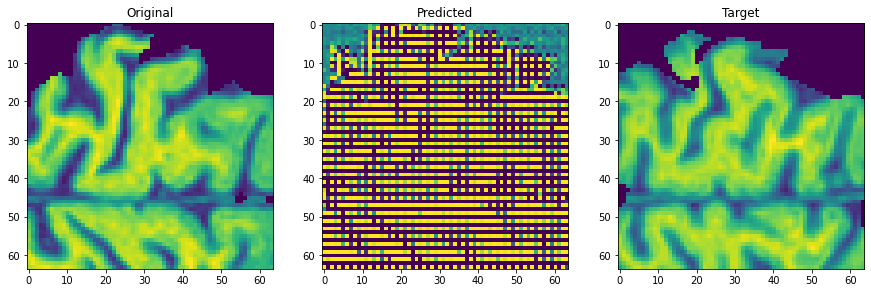

>1, d1[0.487] d2[1.698] g[13496.614]
>1, d1[0.255] d2[0.644] g[21245.023]
>1, d1[0.320] d2[0.453] g[19367.100]
>1, d1[0.386] d2[0.543] g[7851.193]
>1, d1[0.451] d2[0.467] g[22189.582]
>1, d1[0.246] d2[0.156] g[36402.203]
>1, d1[0.139] d2[0.098] g[37069.672]
>1, d1[0.135] d2[0.141] g[20785.807]
>1, d1[0.123] d2[0.119] g[19959.406]
>1, d1[0.033] d2[0.035] g[38407.957]
>1, d1[0.030] d2[0.018] g[40555.254]
>1, d1[0.150] d2[0.206] g[24768.023]
>1, d1[0.164] d2[0.177] g[13251.561]
>1, d1[0.016] d2[0.012] g[31005.635]
>1, d1[0.019] d2[0.012] g[33231.535]
>1, d1[0.064] d2[0.056] g[16749.219]
>1, d1[0.109] d2[0.088] g[4308.588]
>1, d1[0.018] d2[0.018] g[15125.878]
>1, d1[0.014] d2[0.021] g[16322.457]
>1, d1[0.062] d2[0.091] g[5655.469]
>2, d1[0.187] d2[0.130] g[23928.662]
>2, d1[0.027] d2[0.028] g[35729.039]
>2, d1[0.022] d2[0.013] g[33017.129]
>2, d1[0.044] d2[0.055] g[14651.495]
>2, d1[0.018] d2[0.018] g[38117.617]
>2, d1[0.151] d2[0.277] g[52210.387]
>2, d1[0.026] d2[0.024] g[52049.590]
>2, 

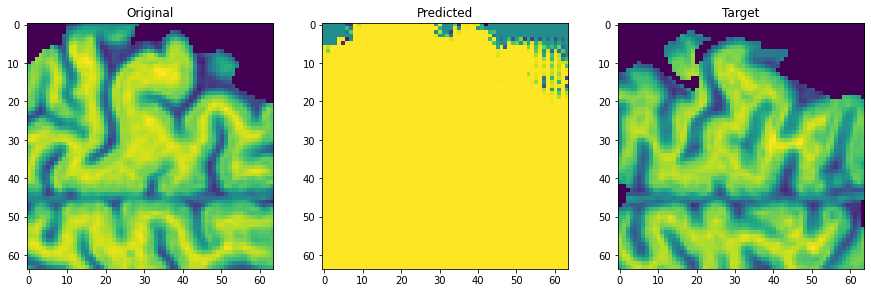

>1, d1[0.051] d2[0.148] g[13470.485]
>1, d1[0.010] d2[0.004] g[21210.795]
>1, d1[0.009] d2[0.005] g[19337.590]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>1, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan]
>2, d1[nan] d2[nan] g[nan

KeyboardInterrupt: ignored

In [50]:
gan.train(d_model, g_model, gan_model, dataset)